In [ ]:
from sklearn.model_selection import train_test_split
from keras.models import load_model
from keras.layers import Input, Embedding, LSTM, TimeDistributed, Dense
from keras.models import Model
from keras_preprocessing.sequence import pad_sequences
from keras import optimizers
from  matplotlib import pyplot as plt
import tensorflow as tf
from sklearn.utils import shuffle
import pandas as pd
import numpy as np
import gzip
import random
import math
import os
import re
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
INPUT_VECTOR_LENGTH = 20 
OUTPUT_VECTOR_LENGTH = 8
SOS = "<SOS>"
EOS = "<EOS>"
GLOVE_MODEL = "glove.6B.50d.txt"

minimum_length_q = 2      # Minimum question text length
maximum_length_q = 20     # Maximum question text length
minimum_length_a = 2      # Minimum answer text length
maximum_length_a = OUTPUT_VECTOR_LENGTH - 2 # Maxomum answer text length
hidden_dim = 400
LEARNING_RATE = 0.0001
#OPTIMIZER = optimizers.SGD(learning_rate=LEARNING_RATE)
OPTIMIZER = optimizers.Adam(learning_rate=LEARNING_RATE)
#OPTIMIZER = optimizers.Adagrad(learning_rate=LEARNING_RATE)
#OPTIMIZER = optimizers.RMSprop(learning_rate=LEARNING_RATE)
BATCH_SIZE = 64
EPOCHS = 20


In [ ]:
def parse(path):
    print(path)
    f = gzip.open(path, 'r')
    for line in f:
        yield eval(line)
    f.close()

def getDF(path):
    index = 0
    df = {}
    for file in os.listdir(path):
        if file[0] != '.':
            for fileData in parse(path + '/' + file):
                df[index] = fileData
                index += 1
    return pd.DataFrame.from_dict(df, orient='index')

def decontracted(phrase):
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

def filter_ques_ans(clean_questions, clean_answers):
    short_questions_temp = []
    short_answers_temp = []
    for i, question in enumerate(clean_questions):
        if len(question.split()) >= minimum_length_q and len(question.split()) <= maximum_length_q:
            short_questions_temp.append(question)
            short_answers_temp.append(clean_answers[i])
    short_questions = []
    short_answers = []
    for i, answer in enumerate(short_answers_temp):
        if len(answer.split()) >= minimum_length_a and len(answer.split()) <= maximum_length_a:
            short_answers.append(answer)
            short_questions.append(short_questions_temp[i])
    return short_questions, short_answers

def create_vocabulary(tokenized_ques,tokenized_ans):
    vocabulary = {}
    for question in tokenized_ques:
        for word in question:
            if word not in vocabulary:
                vocabulary[word] = 1
            else:
                vocabulary[word] += 1
    for answer in tokenized_ans:
        for word in answer:
            if word not in vocabulary:
                vocabulary[word] = 1
            else:
                vocabulary[word] += 1  
    return vocabulary

def create_encoding_decoding(vocabulary):
    threshold = 15
    vocab_size  = 1
    encoding = {}
    decoding = {}
    for word, count in vocabulary.items():
        if count >= threshold:
            encoding[word] = vocab_size 
            decoding[vocab_size] = word
            vocab_size += 1
    return encoding, decoding, vocab_size

def transform(encoding, data, vector_size = 30):
    transformed_data = np.zeros(shape=(len(data), vector_size))
    for i in range(len(data)):
        for j in range(min(len(data[i]), vector_size)):
            try:
                transformed_data[i][j] = encoding[data[i][j]]
            except:
                transformed_data[i][j] = encoding['<UNKNOWN>']
    return transformed_data

def filter_unknown(encoding, data):
    result = []
    for i in data:
        sent = []
        for j in i:
            if j in encoding:
                sent.append(j)
            else:
                sent.append('<UNKNOWN>')
        result.append(sent)
    return result

def create_gloveEmbeddings(encoding,size):
    file = open(GLOVE_MODEL, mode='rt', encoding='utf8')
    words = set()
    word_to_vec_map = {}
    for line in file:
        line = line.strip().split()
        word = line[0]
        words.add(word)
        word_to_vec_map[word] = np.array(line[1:], dtype=np.float64)
    embedding_matrix = np.zeros((size, 50))
    for word,index in encoding.items():
        try:
            embedding_matrix[index, :] = word_to_vec_map[word.lower()]
        except: continue
    return embedding_matrix

def create_model(dict_size,embed_layer,hidden_dim):
    
    encoder_inputs = Input(shape=(maximum_length_q, ), dtype='int32',)

    encoder_embedding = embed_layer(encoder_inputs)
    encoder_LSTM = LSTM(hidden_dim, return_sequences=True, return_state=True)
    encoder_outputs, state_h, state_c = encoder_LSTM(encoder_embedding)

    decoder_inputs = Input(shape=(OUTPUT_VECTOR_LENGTH, ), dtype='int32',)

    decoder_embedding = embed_layer(decoder_inputs)
    decoder_LSTM = LSTM(hidden_dim, return_state=True, return_sequences=True)
    decoder_outputs, _, _ = decoder_LSTM(decoder_embedding, initial_state=[state_h, state_c])
    dense = Dense(dict_size, activation='softmax')
    outputs = (dense)(decoder_outputs)
    # outputs = Dense(dict_size, activation='softmax')(decoder_outputs)
    
    model = Model([encoder_inputs, decoder_inputs], outputs)
    return model
def answer_mod(answers):
    ans = []
    for sen in answers:
        sen = np.concatenate(([SOS], sen, [EOS]))
        ans.append(sen)
    return np.array(ans)
def data_cleaning(raw_data):
    clean_data = []
    for sentence in raw_data:
        sent = decontracted(sentence)
        sent = sent.replace('\\r', ' ')
        sent = sent.replace('\\"', ' ')
        sent = sent.replace('\\n', ' ')
        sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
        sent = sent.lower().strip()
        clean_data.append(sent)
    return clean_data

In [ ]:
fileList = []
for file in os.listdir('Data'):
    fileList.append(file)
df = getDF('Data')    
df = df[["question","answer"]]   
allQuestion = df['question'].tolist()
allAnswer = df['answer'].tolist()
allQuestion, allAnswer = shuffle(allQuestion, allAnswer)
# random.shuffle(allQuestion)
# random.shuffle(allAnswer)
fixDictSize = 0

Data/qa_Appliances.json.gz
Data/qa_Automotive.json.gz
Data/qa_Arts_Crafts_and_Sewing.json.gz
Data/qa_Baby.json.gz


In [ ]:
df.head(5)

,question,answer
0,I have a 9 year old Badger 1 that needs replac...,I replaced my old one with this without a hitch.
1,model number,This may help InSinkErator Model BADGER-1: Bad...
2,can I replace Badger 1 1/3 with a Badger 5 1/2...,Plumbing connections will vary with different ...
3,Does this come with power cord and dishwasher ...,It does not come with a power cord. It does co...
4,loud noise inside when turned on. sounds like ...,Check if you dropped something inside.Usually ...


In [ ]:
question = allQuestion
answer = allAnswer

questionData = data_cleaning(question)
answerData = data_cleaning(answer)
questionData, answerData = filter_ques_ans(questionData, answerData)
questionTokenized = [nltk.word_tokenize(sent) for sent in questionData]
answerTokenized = [nltk.word_tokenize(sent) for sent in answerData]
# answerTokenized = answer_mod(answerTokenized)
vocabulary = create_vocabulary(questionTokenized, answerTokenized)
answerTokenized = answer_mod(answerTokenized) # modify the answer text

<ipython-input-3-aeefa67a28d0>:137: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(ans)


In [ ]:
pd.DataFrame(answerTokenized).rename(columns={0: 'answer'}).head(5)

,answer
0,"[<SOS>, did, youu, trying, the, company, websi..."
1,"[<SOS>, single, outlet, <EOS>]"
2,"[<SOS>, yes, it, will, <EOS>]"
3,"[<SOS>, it, is, sold, by, pair, <EOS>]"
4,"[<SOS>, yes, it, does, no, problem, <EOS>]"


In [ ]:
pd.DataFrame(questionData).rename(columns={0: 'question'}).head(5)

,question
0,where can i purchase an ac adapter for a wagan...
1,is this a 10 pack or single outlet
2,will this add the feature of auto off headligh...
3,confirming is this sold as pair or single
4,will this work on 1999 toyota tacoma


In [ ]:
clean_df = pd.DataFrame()
clean_df['Question'] = pd.DataFrame(questionData)
clean_df['Answer'] = pd.DataFrame(answerTokenized)
clean_df.head(5)

,Question,Answer
0,where can i purchase an ac adapter for a wagan...,"[<SOS>, did, youu, trying, the, company, websi..."
1,is this a 10 pack or single outlet,"[<SOS>, single, outlet, <EOS>]"
2,will this add the feature of auto off headligh...,"[<SOS>, yes, it, will, <EOS>]"
3,confirming is this sold as pair or single,"[<SOS>, it, is, sold, by, pair, <EOS>]"
4,will this work on 1999 toyota tacoma,"[<SOS>, yes, it, does, no, problem, <EOS>]"


In [ ]:
encoding, decoding, dict_size = create_encoding_decoding(vocabulary)
decoding[0] = '<ERR>'
encoding['<ERR>'] = 0
decoding[dict_size] = '<UNKNOWN>'
encoding['<UNKNOWN>'] = dict_size
dict_size += 1
decoding[dict_size] = SOS
encoding[SOS] = dict_size
dict_size += 1
decoding[dict_size] = EOS
encoding[EOS] = dict_size
dict_size += 1
fixDictSize = max(fixDictSize, max(int(len(encoding) + 1), dict_size + 1))


In [ ]:
encoding['<SOS>']

1247

In [ ]:
from keras.utils import to_categorical

size = len(questionTokenized)
trainingInput = questionTokenized[:round(size*(80/100))]
trainingOutput = answerTokenized[:round(size*(80/100))]
validationInput = questionTokenized[round(size*(80/100)):round(size*(95/100))]
validationOutput = answerTokenized[round(size*(80/100)):round(size*(95/100))]
testInput = questionTokenized[round(size*(95/100)):]
testOutput = answerTokenized[round(size*(95/100)):]


encoded_training_input = transform(encoding, trainingInput, vector_size = INPUT_VECTOR_LENGTH)
encoded_training_output = transform(encoding, trainingOutput, vector_size = OUTPUT_VECTOR_LENGTH)

encoded_validation_input = transform(encoding, validationInput, vector_size = INPUT_VECTOR_LENGTH)
encoded_validation_output = transform(encoding, validationOutput, vector_size = OUTPUT_VECTOR_LENGTH)

encoded_test_input = transform(encoding, validationInput, vector_size = INPUT_VECTOR_LENGTH)
encoded_test_output = transform(encoding, validationOutput, vector_size = OUTPUT_VECTOR_LENGTH)

tf.keras.backend.clear_session()
embedding_matrix = np.zeros((dict_size, 50))
embedding_matrix= create_gloveEmbeddings(encoding,dict_size)

embed_layer = Embedding(input_dim = dict_size, output_dim = 50, trainable = True)
embed_layer.build((None,))
embed_layer.set_weights([embedding_matrix])

In [ ]:
encoder_inputs = Input(shape=(maximum_length_q, ), dtype='int32',)

encoder_embedding = embed_layer(encoder_inputs)
encoder_LSTM = LSTM(hidden_dim, return_sequences=True, return_state=True)
encoder_outputs, state_h, state_c = encoder_LSTM(encoder_embedding)
enc_states = [state_h, state_c]
decoder_inputs = Input(shape=(OUTPUT_VECTOR_LENGTH, ), dtype='int32',)

decoder_embedding = embed_layer(decoder_inputs)
decoder_LSTM = LSTM(hidden_dim, return_state=True, return_sequences=True)
decoder_outputs, _, _ = decoder_LSTM(decoder_embedding, initial_state=enc_states)
dense = Dense(dict_size, activation='softmax')
outputs = (dense)(decoder_outputs)

In [ ]:
lstm_model = Model([encoder_inputs, decoder_inputs], outputs)

lstm_model.summary()
lstm_model.compile(optimizer= OPTIMIZER, loss ='categorical_crossentropy', metrics = ['accuracy'])

training_encoder_input = encoded_training_input
training_decoder_input = np.zeros_like(encoded_training_output)
training_decoder_input = encoded_training_output

encoded_training_output = encoded_training_output[:, 1:-1]
encoded_training_output = pad_sequences(encoded_training_output, OUTPUT_VECTOR_LENGTH, padding='post', truncating='post')
training_decoder_output = to_categorical(encoded_training_output, (dict_size))

validation_encoder_input = encoded_validation_input
validation_decoder_input = np.zeros_like(encoded_validation_output)
validation_decoder_input = encoded_validation_output

encoded_validation_output = encoded_validation_output[:, 1:-1]
encoded_validation_output = pad_sequences(encoded_validation_output, OUTPUT_VECTOR_LENGTH, padding='post', truncating='post')
validation_decoder_output = to_categorical(encoded_validation_output, (dict_size))

history = lstm_model.fit(x = [training_encoder_input, training_decoder_input], y = training_decoder_output, validation_data = ([validation_encoder_input, validation_decoder_input], validation_decoder_output), batch_size = BATCH_SIZE, epochs = EPOCHS)
lstm_model.save('lstm_model.h5')

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 8)]          0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 20)]         0           []                               
                                                                                                  
 embedding (Embedding)          multiple             62450       ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 20, 400),    721600      ['embedding[0][0]']          

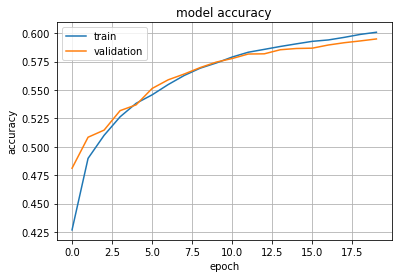

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.grid()
plt.show()

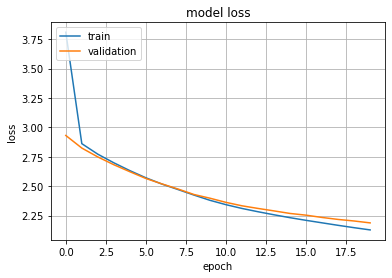

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.grid()
plt.show()

In [ ]:
enc_model = Model([encoder_inputs], enc_states)

decoder_state_input_h = Input(shape=(400,))
decoder_state_input_c = Input(shape=(400,))

decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]


decoder_outputs, state_h, state_c = decoder_LSTM(decoder_embedding , 
                                    initial_state=decoder_states_inputs)


decoder_states = [state_h, state_c]


dec_model = Model([decoder_inputs]+ decoder_states_inputs,
                                      [decoder_outputs]+ decoder_states)



In [ ]:
testInput[0]

['will', 'it', 'fit', '4l80e']

In [ ]:
pred_output = []
count = 0
for i in testInput:
    if count == 10:
        break
    input_tokens = i
    # print(input_tokens)
    encoder_input = transform(encoding, [input_tokens], INPUT_VECTOR_LENGTH)
    # print(encoder_input)
    decoder_input = np.zeros(shape=(len(encoder_input), OUTPUT_VECTOR_LENGTH))
    decoder_input[:,0] = encoding[SOS]

    stat = enc_model.predict( encoder_input )

    empty_target_seq = np.zeros( ( 1 , 1) )
    empty_target_seq[0, 0] = encoding['<SOS>']

    stop_condition = False
    decoded_translation = ''

    while not stop_condition :
        dec_outputs , h, c= dec_model.predict([ empty_target_seq] + stat )
        decoder_concat_input = dense(dec_outputs)
        sampled_word_index = np.argmax( decoder_concat_input[0, -1, :] )
        sampled_word = decoding[sampled_word_index] + ' '

        if sampled_word != '<EOS> ':
            decoded_translation += sampled_word

        if sampled_word == '<EOS> ' or len(decoded_translation.split()) > 13:
            stop_condition = True 

        empty_target_seq = np.zeros( ( 1 , 1 ) )  
        empty_target_seq[ 0 , 0 ] = sampled_word_index
        stat = [h, c]
    pred_output.append(decoded_translation)
    print("email attention : ", decoded_translation )
    count += 1;



1/1 [==============================] - 0s 361ms/step


1/1 [==============================] - 0s 16ms/step
email attention :  yes it will 
1/1 [==============================] - 0s 16ms/step
email attention :  yes it does 
1/1 [==============================] - 0s 16ms/step
email attention :  <UNKNOWN> <UNKNOWN> 
1/1 [==============================] - 0s 16ms/step
email attention :  it is a <UNKNOWN> 
1/1 [==============================] - 0s 16ms/step
email attention :  yes it does 
1/1 [==============================] - 0s 16ms/step
email attention :  yes it is 
1/1 [==============================] - 0s 16ms/step
email attention :  yes it will 
1/1 [==============================] - 0s 16ms/step
email attention :  yes it does 
1/1 [==============================] - 0s 18ms/step
email attention :  yes it will 
1/1 [==============================] - 0s 17ms/step
email attention :  it is a pair 


In [ ]:
truth = testOutput[0:10]
truth = [(i[1:-1]) for i in truth]

In [ ]:
print([" ".join(i) for i in testInput[0:10]])

['will it fit 4l80e', 'does this block access to the front tow tie down points', 'what is the polyester polyamide blend ratio', 'what is the number for a dana 30 cover', 'can the bassinet sit on the ground i e without the frame', 'is this the correct element for a frigidaire wall oven rbe e 94', 'i need a shift cable for my trailblaizer 2002 somebody know which one i can get', 'does this pen come with any tips', 'this will fit in skyline v35 sedan', 'is this a single pad or a set of 2']


In [ ]:
truth = filter_unknown(encoding, truth)
truth

[['i', 'used', 'it', 'on', 'a', '<UNKNOWN>'],
 ['no', 'it', 'does', 'not'],
 ['75', 'polyester', 'and', '25', '<UNKNOWN>'],
 ['40', '<UNKNOWN>', 'is', 'correct'],
 ['no', 'it', 'can', 'not'],
 ['yes', 'that', 'is', 'the', 'correct', 'one'],
 ['ac', '<UNKNOWN>', '<UNKNOWN>'],
 ['yes', 'it', 'did'],
 ['yes', 'it', 'will', 'fit'],
 ['set', 'of', '2']]

In [ ]:
pred_output

['yes it will ',
 'yes it does ',
 '<UNKNOWN> <UNKNOWN> ',
 'it is a <UNKNOWN> ',
 'yes it does ',
 'yes it is ',
 'yes it will ',
 'yes it does ',
 'yes it will ',
 'it is a pair ']

In [ ]:
from nltk.translate.bleu_score import sentence_bleu
num = 10
score = 0.0
for i in range(10):
    score += sentence_bleu([truth[i]], pred_output[i].split(), weights=(1.0, 0, 0, 0))
score /= 10
print('BLEU: %f' % score)

BLEU: 0.307917


/usr/local/lib/python3.8/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.8/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.8/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg

In [ ]:
# prepro1 = ""
# while prepro1 != 'q':
#     prepro1  = input("Question : ")

#     transformed_input = decontracted(prepro1)
#     transformed_input = transformed_input.replace('\\r', ' ')
#     transformed_input = transformed_input.replace('\\"', ' ')
#     transformed_input = transformed_input.replace('\\n', ' ')
#     transformed_input = re.sub('[^A-Za-z0-9]+', ' ', transformed_input)
#     transformed_input = transformed_input.lower().strip()
#     input_tokens = [nltk.word_tokenize(transformed_input)]
#     encoder_input = transform(encoding, input_tokens, INPUT_VECTOR_LENGTH)
#     decoder_input = np.zeros(shape=(len(encoder_input), OUTPUT_VECTOR_LENGTH))
#     decoder_input[:,0] = encoding[SOS]

#     print(encoder_input)
#     stat = enc_model.predict( encoder_input )

#     empty_target_seq = np.zeros( ( 1 , 1) )
#     empty_target_seq[0, 0] = encoding['<SOS>']

#     stop_condition = False
#     decoded_translation = ''

#     while not stop_condition :
#         dec_outputs , h, c= dec_model.predict([ empty_target_seq] + stat )
#         decoder_concat_input = dense(dec_outputs)
#         sampled_word_index = np.argmax( decoder_concat_input[0, -1, :] )
#         sampled_word = decoding[sampled_word_index] + ' '

#         if sampled_word != '<EOS> ':
#             decoded_translation += sampled_word  

#         if sampled_word == '<EOS> ' or len(decoded_translation.split()) > 13:
#             stop_condition = True 

#         empty_target_seq = np.zeros( ( 1 , 1 ) )  
#         empty_target_seq[ 0 , 0 ] = sampled_word_index
#         stat = [h, c]  

#     print("email reply: ", decoded_translation )
#     print("==============================================")  

In [ ]:
# # g!unzip Data.zip
# !unzip glove.6B.50d.txt.zip